# Retail Price Optimization and Demand Forecasting

This project aims to build a predictive model that estimates product demand (quantity sold) based on various pricing factors such as own price, competitor pricing, freight costs, and product category. The objective is to simulate pricing scenarios that help drive decisions on:

- Optimal pricing strategy
- Impact of competitor prices
- Category-level performance
- Profit-maximizing price points

In [280]:
import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

In [281]:
df = pd.read_csv("retail_price.csv")
df.info()
df.describe()
df.isnull().sum()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,1/5/2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,1/6/2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,1/7/2017,6,275.70,14.840000,45.95,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,1/8/2017,4,183.80,14.287500,45.95,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,1/9/2017,2,91.90,15.100000,45.95,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


## Dataset Description

The dataset includes transactional-level data with the following key columns:

- `unit_price`: The price at which the product was sold
- `qty`: Number of units sold (target variable)
- `freight_price`: Shipping cost per unit
- `comp_1`, `comp_2`, `comp_3`: Competitor prices
- `product_category_name`: Product category
- `month_year`: Date of transaction

Additional columns such as revenue, profit, and price gaps were engineered to improve model inputs and interpretability.

In [282]:
df['month_year'] = pd.to_datetime(df['month_year'], dayfirst=True)
df['month_year'].head()

0   2017-05-01
1   2017-06-01
2   2017-07-01
3   2017-08-01
4   2017-09-01
Name: month_year, dtype: datetime64[ns]

In [283]:
df['revenue'] = df['unit_price'] * df['qty']
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,revenue
0,bed1,bed_bath_table,2017-05-01,1,45.95,15.100000,45.95,39,161,2,...,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90,45.95
1,bed1,bed_bath_table,2017-06-01,3,137.85,12.933333,45.95,39,161,2,...,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95,137.85
2,bed1,bed_bath_table,2017-07-01,6,275.70,14.840000,45.95,39,161,2,...,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95,275.70
3,bed1,bed_bath_table,2017-08-01,4,183.80,14.287500,45.95,39,161,2,...,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95,183.80
4,bed1,bed_bath_table,2017-09-01,2,91.90,15.100000,45.95,39,161,2,...,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95,91.90


In [284]:
df['profit'] = (df['unit_price'] - df['freight_price']) * df['qty']
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,revenue,profit
0,bed1,bed_bath_table,2017-05-01,1,45.95,15.100000,45.95,39,161,2,...,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90,45.95,30.85
1,bed1,bed_bath_table,2017-06-01,3,137.85,12.933333,45.95,39,161,2,...,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95,137.85,99.05
2,bed1,bed_bath_table,2017-07-01,6,275.70,14.840000,45.95,39,161,2,...,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95,275.70,186.66
3,bed1,bed_bath_table,2017-08-01,4,183.80,14.287500,45.95,39,161,2,...,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95,183.80,126.65
4,bed1,bed_bath_table,2017-09-01,2,91.90,15.100000,45.95,39,161,2,...,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95,91.90,61.70


Competitor price differences

In [285]:
df['price_diff_vs_comp1'] = df['unit_price'] - df['comp_1']
df['price_diff_vs_comp2'] = df['unit_price'] - df['comp_2']
df['price_diff_vs_comp3'] = df['unit_price'] - df['comp_3']
df[['unit_price', 'qty', 'freight_price', 'revenue', 'profit', 
    'price_diff_vs_comp1', 'price_diff_vs_comp2', 'price_diff_vs_comp3']].head()

,unit_price,qty,freight_price,revenue,profit,price_diff_vs_comp1,price_diff_vs_comp2,price_diff_vs_comp3
0,45.95,1,15.100000,45.95,30.85,-43.95,-169.050000,0.0
1,45.95,3,12.933333,137.85,99.05,-43.95,-163.050000,0.0
2,45.95,6,14.840000,275.70,186.66,-43.95,-159.050000,0.0
3,45.95,4,14.287500,183.80,126.65,-43.95,-153.559804,0.0
4,45.95,2,15.100000,91.90,61.70,-43.95,-117.448710,0.0


## Exploratory Data Analysis

We start by visualizing the relationship between unit price and quantity sold, along with how profit varies across product categories. We also explore the distribution of price differences with competitors to understand how price competitiveness influences performance.

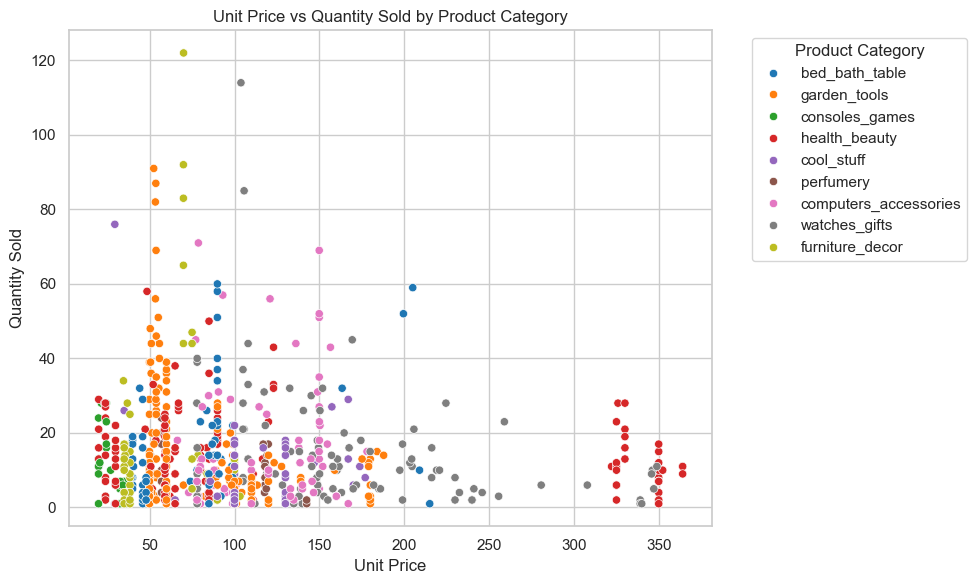

In [286]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x='unit_price',
    y='qty',
    hue='product_category_name',
    palette='tab10'  
)

plt.title('Unit Price vs Quantity Sold by Product Category')
plt.xlabel('Unit Price')
plt.ylabel('Quantity Sold')

plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

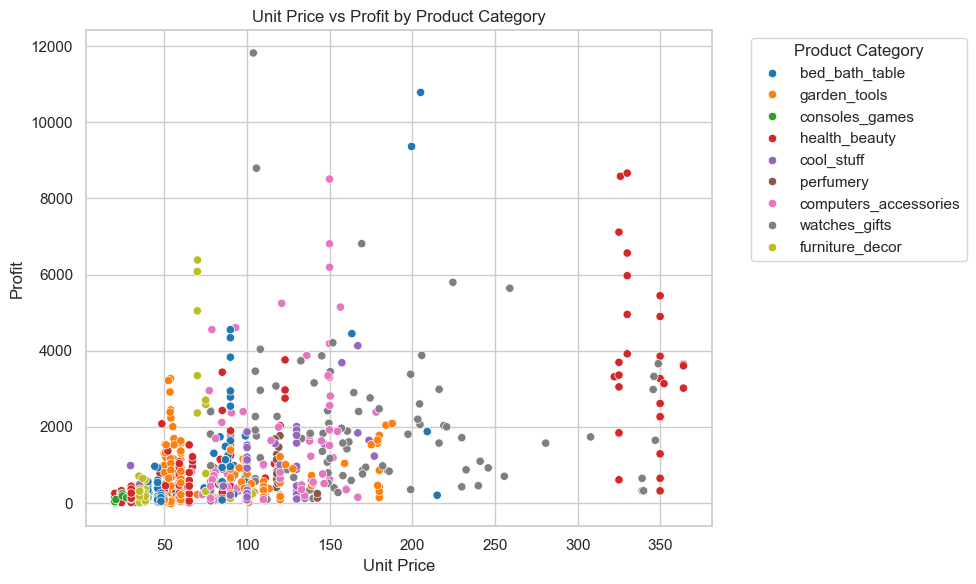

In [287]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x='unit_price',
    y='profit',
    hue='product_category_name',
    palette='tab10'  
)

plt.title('Unit Price vs Profit by Product Category')
plt.xlabel('Unit Price')
plt.ylabel('Profit')

plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

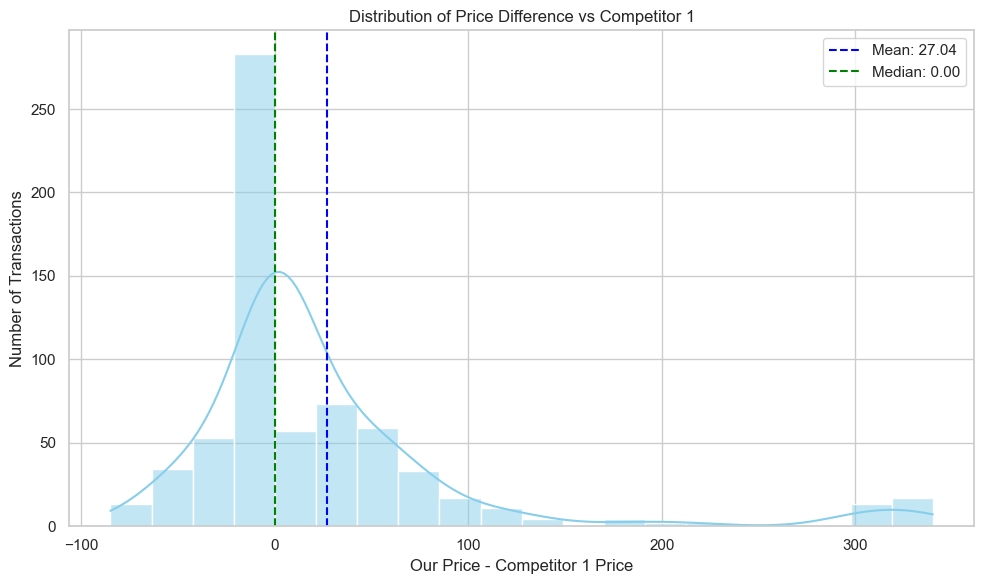

In [288]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price_diff_vs_comp1'], bins=20, kde=True, color='skyblue')
mean_diff = df['price_diff_vs_comp1'].mean()
median_diff = df['price_diff_vs_comp1'].median()
plt.axvline(mean_diff, color='blue', linestyle='--', label=f'Mean: {mean_diff:.2f}')
plt.axvline(median_diff, color='green', linestyle='--', label=f'Median: {median_diff:.2f}')
plt.title('Distribution of Price Difference vs Competitor 1')
plt.xlabel('Our Price - Competitor 1 Price')
plt.ylabel('Number of Transactions')
plt.legend()
plt.tight_layout()
plt.show()

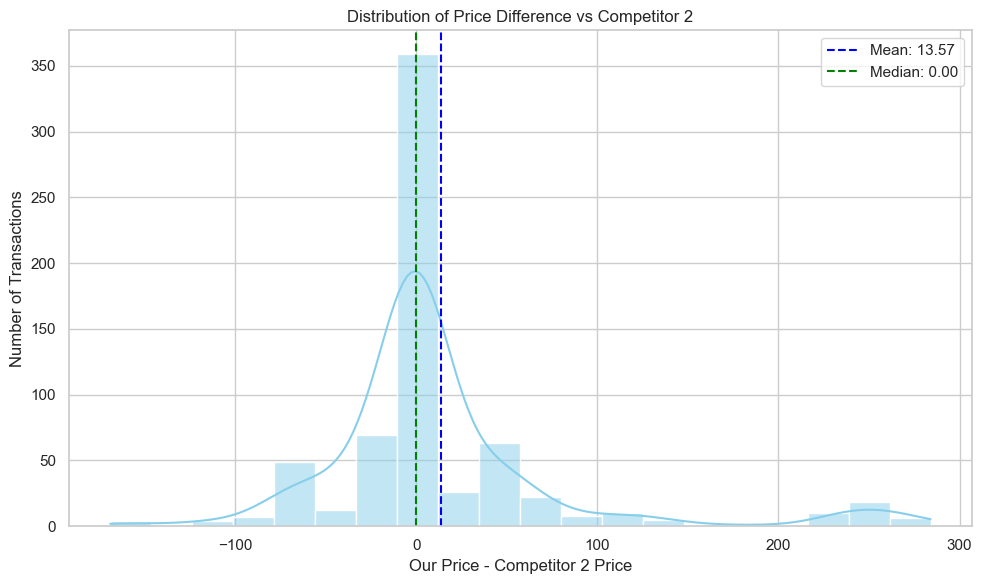

In [289]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price_diff_vs_comp2'], bins=20, kde=True, color='skyblue')
mean_diff = df['price_diff_vs_comp2'].mean()
median_diff = df['price_diff_vs_comp2'].median()
plt.axvline(mean_diff, color='blue', linestyle='--', label=f'Mean: {mean_diff:.2f}')
plt.axvline(median_diff, color='green', linestyle='--', label=f'Median: {median_diff:.2f}')
plt.title('Distribution of Price Difference vs Competitor 2')
plt.xlabel('Our Price - Competitor 2 Price')
plt.ylabel('Number of Transactions')
plt.legend()
plt.tight_layout()
plt.show()

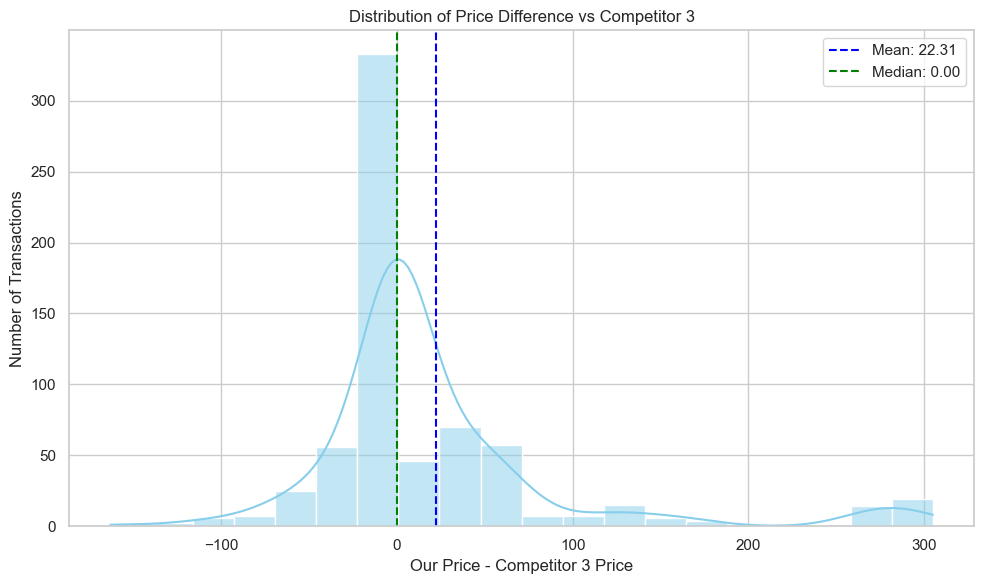

In [290]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price_diff_vs_comp3'], bins=20, kde=True, color='skyblue')
mean_diff = df['price_diff_vs_comp3'].mean()
median_diff = df['price_diff_vs_comp3'].median()
plt.axvline(mean_diff, color='blue', linestyle='--', label=f'Mean: {mean_diff:.2f}')
plt.axvline(median_diff, color='green', linestyle='--', label=f'Median: {median_diff:.2f}')
plt.title('Distribution of Price Difference vs Competitor 3')
plt.xlabel('Our Price - Competitor 3 Price')
plt.ylabel('Number of Transactions')
plt.legend()
plt.tight_layout()
plt.show()

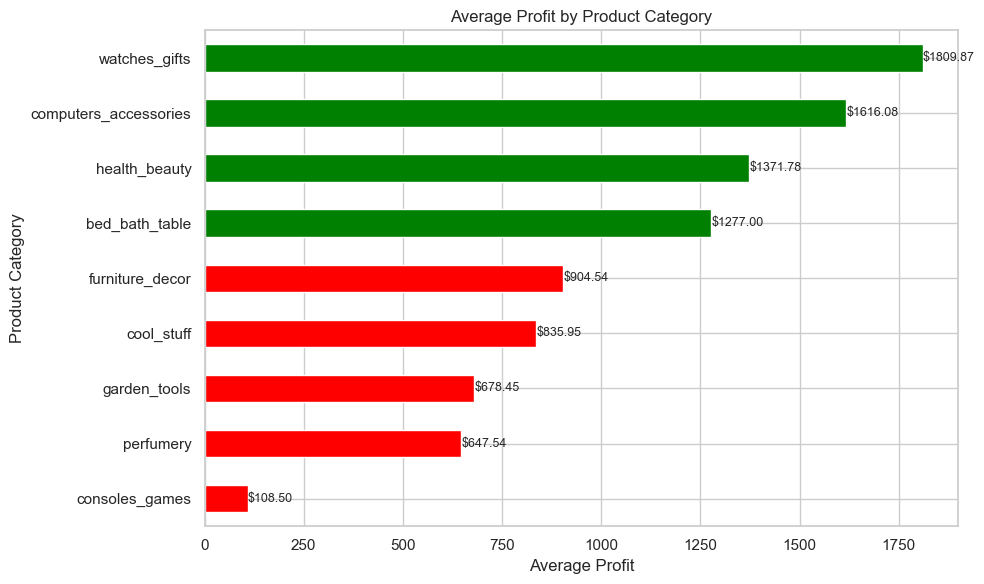

In [291]:
category_profit = df.groupby('product_category_name')['profit'].mean().sort_values()
plt.figure(figsize=(10, 6))

colors = ['red' if val < 1000 else 'green' for val in category_profit]

bars = category_profit.plot(kind='barh', color=colors)
plt.title('Average Profit by Product Category')
plt.xlabel('Average Profit')
plt.ylabel('Product Category')

for index, value in enumerate(category_profit):
    plt.text(value + 1, index, f'${value:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


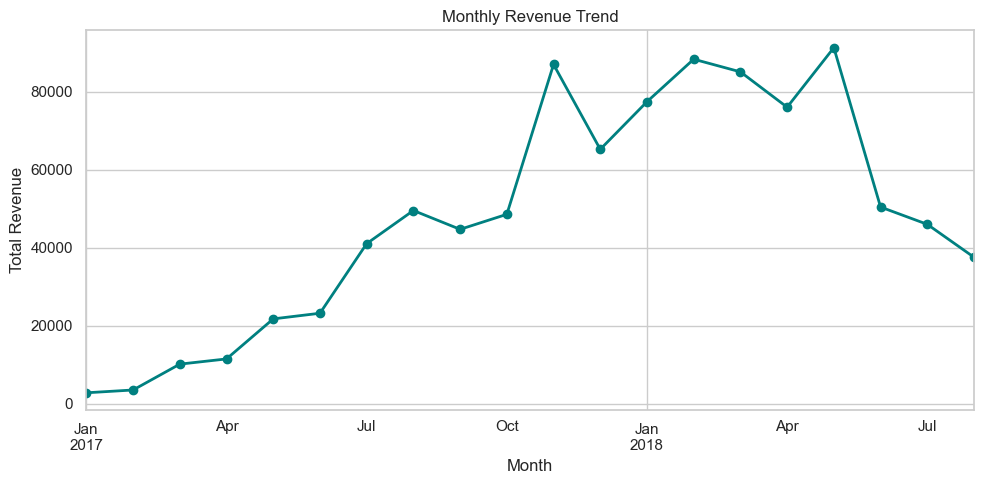

In [292]:
monthly_revenue = df.groupby('month_year')['revenue'].sum()
plt.figure(figsize=(10, 5)) 
monthly_revenue.plot(marker='o', color='teal', linewidth=2) 
plt.title('Monthly Revenue Trend')  
plt.xlabel('Month')  
plt.ylabel('Total Revenue')  
plt.grid(True)  
plt.tight_layout()  
plt.show()  

## Model Training: XGBoost Regressor

To model demand, we use XGBoost — a high-performance, tree-based regression model suitable for tabular data.

- The target variable `qty` is log-transformed to reduce skew and stabilize variance.
- Temporal features (`month`, `year`, `quarter`) and categorical encodings are included.
- The model is evaluated using MAE, RMSE, and MAPE on the original quantity scale.

In [293]:
df['month_year'] = pd.to_datetime(df['month_year'], dayfirst=True)
df['month'] = df['month_year'].dt.month
df['year'] = df['month_year'].dt.year
df['quarter'] = df['month_year'].dt.quarter

category_dummies = pd.get_dummies(df['product_category_name'], drop_first=True)

X_numeric = df[['unit_price', 'comp_1', 'comp_2', 'comp_3', 'freight_price', 'month', 'year', 'quarter']]
X = pd.concat([X_numeric, category_dummies], axis=1)
X = X.astype("float64")

df['log_qty'] = np.log1p(df['qty'])
y = df['log_qty']

X_train, X_test, y_train, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_raw)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\n📊 Final Model Performance (on original qty scale):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")



📊 Final Model Performance (on original qty scale):
MAE: 8.21
RMSE: 12.00
MAPE: 172.38%


## Model Evaluation

The model is evaluated on the test set. Predictions are transformed back from the log scale. Here's how well it performed in predicting quantity sold:

- MAE (Mean Absolute Error): Average number of units off
- RMSE (Root Mean Squared Error): Heavily penalizes larger errors
- MAPE (Mean Absolute Percentage Error): Percentage error relative to actual quantity

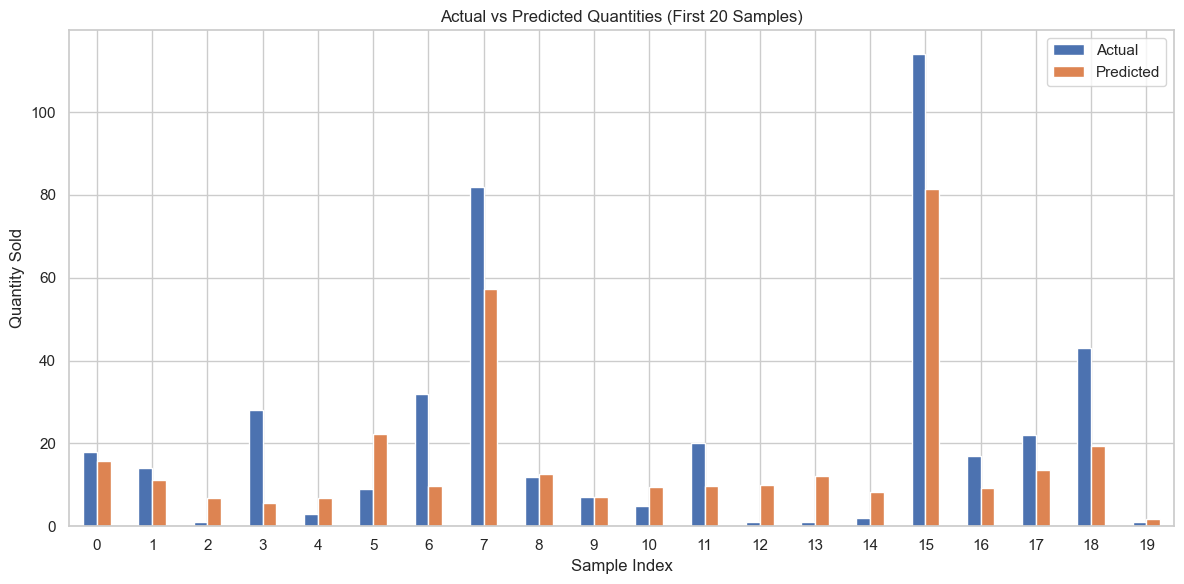

In [294]:
sample = pd.DataFrame({
    'Actual': y_test.values[:20],
    'Predicted': y_pred[:20]
}).reset_index(drop=True)

sample.plot(kind='bar', figsize=(12, 6))
plt.title("Actual vs Predicted Quantities (First 20 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Importance

XGBoost provides a built-in feature importance metric, which we use to understand which features most influence demand prediction.

In [295]:
def simulate_price_scenario(new_price, unit_cost, comp1, comp2, comp3, freight, category, month=1, year=2023, quarter=None):
    if quarter is None:
        quarter = (month - 1) // 3 + 1

    input_dict = {
        'unit_price': [new_price],
        'comp_1': [comp1],
        'comp_2': [comp2],
        'comp_3': [comp3],
        'freight_price': [freight],
        'month': [month],
        'year': [year],
        'quarter': [quarter],
    }

    for col in category_dummies.columns:
        input_dict[col] = [1 if col == category else 0]

    input_df = pd.DataFrame(input_dict)
    input_df = input_df[X.columns]

    log_pred = model.predict(input_df)
    qty_pred = np.expm1(log_pred[0])

    profit = (new_price - unit_cost - freight) * qty_pred

    return round(qty_pred, 2), round(profit, 2)


### Change the values below to simulate **What-if** scenarios better

In [296]:
qty, profit = simulate_price_scenario(
    new_price=55,
    unit_cost=30,
    comp1=65,
    comp2=45,
    comp3=55,
    freight=10,
    category='computers_accessories',
    month=4,
    year=2025
)

print(f"Predicted Quantity: {qty}")
print(f"Estimated Profit: ${profit}")


Predicted Quantity: 30.18000030517578
Estimated Profit: $452.7


In [298]:
df_export = df.copy()
df_export['month_year'] = pd.to_datetime(df_export['month_year'], dayfirst=True)
df_export['price_diff_vs_comp1'] = df_export['unit_price'] - df_export['comp_1']
df_export['price_diff_vs_comp2'] = df_export['unit_price'] - df_export['comp_2']
df_export['price_diff_vs_comp3'] = df_export['unit_price'] - df_export['comp_3']
df_export['profit'] = (df_export['unit_price'] - df_export['freight_price']) * df_export['qty']

selected_cols = [
    'month_year', 'product_category_name', 'unit_price', 'comp_1', 'comp_2', 'comp_3',
    'price_diff_vs_comp1', 'price_diff_vs_comp2', 'price_diff_vs_comp3',
    'qty', 'freight_price', 'profit'
]

df_export[selected_cols].to_csv("C:/Users/Vedant/Desktop/Portfolio/Price Optimization/tableau_ready.csv", index=False)

## Conclusion and Business Takeaways

- The model successfully predicts quantity sold with reasonable accuracy.
- Features like own price, freight cost, and competitor pricing significantly influence demand.
- The simulator can be used by pricing teams to test different strategies for each category.

### Potential Enhancements
- Include promotional or seasonal flags
- Tune hyperparameters further using grid search
- Aggregate demand to weekly or monthly level to reduce noise
- Build a price elasticity curve to visualize impact of price changes

This project provides a strong foundation for data-driven pricing decisions in a retail environment.